In [1]:
GPT_CONFIG_124 = {
    "vocab_size" : 50257,
    "context_length" : 256,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}



# Transformer Block 

In [2]:
import torch
from torch import nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [4]:
class TransformerBlock(nn.Module) : 
    def __init__(self,cfg) :
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        
        
    def forward(self, x) :
        shortcut = x
        # input dim : [batch_size, num_tokens,emb_dim]
        x = self.norm1(x)
        x = self.att(x) 
        # after the attention mechanism we get context vectors
        x = self.drop_shortcut(x)
        # dim : [batch_size, num_tokens, emb_dim]
        
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x
        

In [5]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
# input : [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124)
out = block(x)

total_params = sum(p.numel() for p in block.parameters())
print(f"Number of parameters: {total_params}")
print(x.shape)
print(out.shape)

Number of parameters: 7085568
torch.Size([2, 4, 768])
torch.Size([2, 4, 768])


In [6]:
## Final GPT Model : 

class GPTModel(nn.Module) :
    def __init__(self, cfg) :
        super().__init__();
        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )
        
    def forward(self, in_idx) : 
        batch_size, seq_len = in_idx.shape
        # seq_len == number of tokens
        tok_embeds = self.token_emb(in_idx)
        # assume a input has a 4 token : 
        # so the positions of the 4 tokens are 0,1,2,3 (torch.arange)
        # pos_emb will find positional embedding for the 4 positions
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds + pos_embeds
        # x ==> [batch_size, num_tokens, emb_dim]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        # x ==> [batch_size, num_tokens, emb_dim]
        logits = self.out_head(x)
        # logits ==> [batch_size, num_tokens, vocab_size]
        return logits

In [7]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124)
batch = torch.tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
print(batch)
out = model(batch)
print(out.shape)
print(out)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
torch.Size([2, 4, 50257])
tensor([[[-0.4708,  0.5737, -0.5967,  ...,  0.2019, -0.5665,  0.1800],
         [-0.3895, -0.1978, -0.8885,  ...,  0.2242, -1.2341,  0.1752],
         [ 0.6973, -0.3432, -0.6080,  ...,  0.3747, -0.6967,  0.1088],
         [-0.2962, -0.6957, -1.1371,  ...,  0.3579,  0.3058, -0.2915]],

        [[-0.1514,  0.3329, -0.9740,  ..., -0.1368, -0.6974, -0.1851],
         [-0.4894, -0.3492, -0.9759,  ...,  0.2951, -0.3396,  0.2109],
         [ 0.5082, -0.1425,  0.2549,  ...,  0.1618,  0.1304, -0.3092],
         [-0.4146, -0.0514, -0.5187,  ..., -0.1869, -0.1303, -0.4969]]],
       grad_fn=<UnsafeViewBackward0>)


In [8]:
# output shape [batch_size, num_tokens, vocab_size] represents that
# for each input,there are num_tokens tokens, and for each token,
# there are 50,000 words to look upon, and output for each token, 
# the ouput is from one of the 50,000 words

# Params

In [9]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

162419712


In [10]:
print("Token embedding layer shape:", model.token_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [11]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(total_params_gpt2)

123822336


In [12]:
# Weight tying :
#  GPT-2 architecture is reusing the weights from the token 
# embedding layer in its output layer.


# Memory : 
# each param : 32 bit float : 4 BYTES
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size is {total_size_mb:.2f} MB")

Total size is 619.58 MB


In [13]:
def generate_text_simple(model, idx, max_new_tokens, context_size) :
    # idx is (batch_size, num_tokens)
    
    for _ in range(max_new_tokens) :
        # crop the current context if it exceeds the supported context size :
        # from last
        idx_cond = idx[:, -context_size:]
        # the above applies cropping for the last dimension only
        
        with torch.no_grad() : 
            logits = model(idx_cond)
        # logits : [batch_size, num_tokens, 50,000 tokens]
            
        # extract the last one
        logits = logits[:,-1, :]
#         print(logits.shape)
        # [batch_size, vocab_size]
        # this represents : there are batch_size inputs in a given batch
        # and for each input, there are 50,000 words available
        
        # probs :
        probs = torch.softmax(logits, dim = -1)
        
        idx_next = torch.argmax(probs, dim = -1, keepdim = True)
#         print(idx_next)
#         print(idx_next.shape)
        # idx_next : [batch_size, 1]
        # for every input there is 1 ouput ready
        idx = torch.cat((idx, idx_next),dim = -1)
        # (batch_size, n_tokens + 1)
        
        # final output : [batch_size, num_tokens + n]
        
    return idx
        
        

In [14]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

start_context = "Hello, I am"
encoded = torch.tensor(tokenizer.encode(start_context)).unsqueeze(0)
print(encoded)



tensor([[15496,    11,   314,   716]])


In [15]:
model.eval()
out = generate_text_simple(
    model,
    idx = encoded,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124["context_length"]
)
print(out)

tensor([[15496,    11,   314,   716, 13240, 11381,  4307,  7640, 16620, 34991]])


In [16]:
decoded_text = tokenizer.decode(out.squeeze(dim = 0).tolist())
print(decoded_text)

Hello, I am Laur inhab DistrinetalkQueue


In [17]:
def text_to_token_ids(text, tokenizer) :
    encoded = tokenizer.encode(text,allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    # [batch_size, num_tokens] OR [no. of batches, batch_size]
    
    return encoded_tensor

def tokens_ids_to_text(token_ids, tokenizer) :
    # [batch_size, n_tokens + n(new tokens)]
    flat = token_ids.squeeze(0);
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens= 10,
    context_size = GPT_CONFIG_124["context_length"]
)

print(tokens_ids_to_text(token_ids, tokenizer))

Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [18]:
# Calculating the loss : 
inputs = torch.tensor([[16833, 3626, 6100], #"Every effort moves"
                      [40, 1107, 588]]) 

targets = torch.tensor([[3626, 6100, 345],
                       [1107, 588, 11311]]) # Effort moves you

print(inputs.shape)

torch.Size([2, 3])


In [19]:
with torch.no_grad() :
    logits = model(inputs)
# print(logits.shape)

probs = torch.softmax(logits, dim = -1)
out = torch.argmax(probs, dim = -1)
print(out.shape)

torch.Size([2, 3])


In [20]:
print(f"Targets batch 1 : {tokens_ids_to_text(targets[0], tokenizer)}")
print(f"Targets batch 2 : {tokens_ids_to_text(out[0], tokenizer)}")


Targets batch 1 :  effort moves you
Targets batch 2 :  Armed heNetflix


In [21]:
# Cross Entropy Loss :

# this is easy bro !! Just chill out for now



In [22]:
text_idx = 0
target_probs_1 = probs[text_idx, [0,1,2], targets[text_idx]]
target_probs_1

text_idx = 1
target_probs_2 = probs[text_idx, [0,1,2], targets[text_idx]]

# target_probs_2

# the above are the probalitites of the target tokens in the softmaxed
# logits(probs)


In [23]:
# Compute the log of all probs :
log_probs = torch.log(torch.cat((target_probs_1, target_probs_2)))
print(log_probs)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [24]:
# Avg hese: 
avg_log_probs = torch.mean(log_probs)
print(avg_log_probs)
# goal is to make the avg log probs as large as possible
# the largest possible val due to log : 0

tensor(-10.7940)


In [25]:
neg_avg_log_probs = avg_log_probs * -1
print(neg_avg_log_probs)
## Now we have to minimize this as close to 0

tensor(10.7940)


In [26]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file :
    text_data = file.read()
    

In [27]:
text_data[-99:]

'it for me! The Strouds stand alone, and happen once--but there\'s no exterminating our kind of art."'

In [28]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(total_characters)
print(total_tokens)

20479
5145


In [29]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset) : 
    def __init__(self, txt, tokenizer, max_length, stride) : 
        self.input_ids = []
        self.target_ids = []
        
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        
        for i in range(0,len(token_ids) - max_length, stride) :
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1 : i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
    def __len__(self) : 
        return len(self.input_ids)
        
    def __getitem__(self, idx) : 
        return self.input_ids[idx], self.target_ids[idx]
    

In [30]:
# DataLoader
def create_dataloader_v1(txt, batch_size = 4, max_length = 256, stride = 128, shuffle = True, drop_last = True, num_workers = 0) : 
    
    tokenizer = tiktoken.get_encoding("gpt2")
    
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    
    # Dataloader : 
    dataloader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        drop_last = drop_last,
        num_workers = num_workers
    )
    
    return dataloader
    

In [31]:
dataloader = create_dataloader_v1(text_data)

X, y = next(iter(dataloader))
X.shape, y.shape

(torch.Size([4, 256]), torch.Size([4, 256]))

In [32]:
# splitting the data into train and test 
train_ratio = 0.90
split_idx = int(len(text_data)*train_ratio)

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_length=GPT_CONFIG_124["context_length"],
    stride = GPT_CONFIG_124["context_length"],
    drop_last = True,
    shuffle = True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size = 2,
    max_length=GPT_CONFIG_124["context_length"],
    stride = GPT_CONFIG_124["context_length"],
    drop_last = True,
    shuffle = True,
    num_workers=0
)


In [33]:
for X,y in train_loader : 
    print(X.shape, y.shape)
    
print("validation loader")
for X,y in val_loader : 
    print(X.shape, y.shape)
    
print("Number of batches : ", len(train_loader))

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
validation loader
torch.Size([2, 256]) torch.Size([2, 256])
Number of batches :  9


In [34]:
def calc_loss_batch(input_batch, target_batch, model, device) : 
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None) : 
    total_loss = 0.
    
    if len(data_loader) == 0 : 
        return float("nan")
    elif num_batches is None : 
        num_batches = len(data_loader)
    else : 
        num_batches = min(num_batches, len(data_loader))
        
    for i, (input_batch, target_batch) in enumerate(data_loader) : 
        if i < num_batches : 
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else :
            break
    return total_loss / num_batches # returning the average loss

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [36]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad() : 
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss : ", train_loss)
print("Validation loss : ", val_loss)

Training loss :  10.987583796183268
Validation loss :  10.981104850769043


In [37]:
# Coding the training loop of the GPT 2 : 

def train_model_simple(model, train_loader, test_loader, optimizer, device, num_epochs,
                      eval_freq, eval_iter, start_context, tokenizer) : 
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs) :
        model.train() # training mode :
        
        # strict training :
        for input_batch, target_batch in train_loader : 
            optimizer.zero_grad() # reset the gradients
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # update the loss gradients
            optimizer.step() #update the model weights
            tokens_seen += input_batch.numel() # returns the total tokens in input_batch
            global_step += 1
            
            # optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch : {epoch} (Step {global_step:06d}) :")
                print(f"Train loss {train_loss:.3f}, Val loss : {val_loss:.3f}")
            
        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
        
    return train_losses, val_losses, track_tokens_seen
            

In [38]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter) : 
    model.eval()
    with torch.no_grad() : 
        train_loss = calc_loss_loader(train_loader,model, device, num_batches = eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [39]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    # encoded : [batch_size = 1, num_tokens]
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = tokens_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [41]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay=0.1)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch : 0 (Step 000000) :
Train loss 9.825, Val loss : 9.931
Epoch : 0 (Step 000005) :
Train loss 7.924, Val loss : 8.341
Every effort moves you,,,,,,,,,,,,,,.                                   
Epoch : 1 (Step 000010) :
Train loss 6.587, Val loss : 7.044
Epoch : 1 (Step 000015) :
Train loss 5.987, Val loss : 6.591
Every effort moves you, the, the, the, the, the, the, the. ", the,,, the,, the,,, the,, the, and, the, the,, the, the, the,, the,
Epoch : 2 (Step 000020) :
Train loss 15.786, Val loss : 15.871
Epoch : 2 (Step 000025) :
Train loss 5.587, Val loss : 6.444
Every effort moves you.  "--. I had. I had been. G. I had, and I had. Gis, and, and. I had. I had to the his his the--, and, and--. Gis. I
Epoch : 3 (Step 000030) :
Train loss 5.026, Val loss : 6.349
Epoch : 3 (Step 000035) :
Train loss 4.695, Val loss : 6.247
Every effort moves you, I was, I had the of the to the picture. "I had to the picture, I was, I had to me, I had the the of the, I had the picture to the, I had the, I 

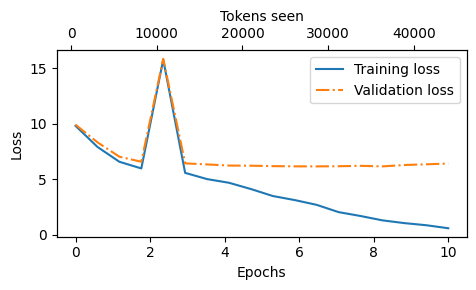

In [42]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)